In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import random
import os
import json
from PIL import Image
import os
import random
import torch
from torchvision import transforms


计算与原型的距离

In [7]:
def pairwise_distances(x: torch.Tensor,
                       y: torch.Tensor,
                       matching_fn: str) -> torch.Tensor:
    EPSILON = 1e-8
    """Efficiently calculate pairwise distances (or other similarity scores) between
    two sets of samples.

    # Arguments
        x: Query samples. A tensor of shape (n_x, d) where d is the embedding dimension
        y: Class prototypes. A tensor of shape (n_y, d) where d is the embedding dimension
        matching_fn: Distance metric/similarity score to compute between samples
    """
    n_x = x.shape[0]
    n_y = y.shape[0]

    if matching_fn == 'l2':
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        x = x.expand(n_x, n_y, -1)
        y = y.expand(n_x, n_y, -1)
        distances = (
                x - y
                
        ).pow(2).sum(dim=2)
        return distances
    elif matching_fn == 'cosine':
        normalised_x = x / (x.pow(2).sum(dim=1, keepdim=True).sqrt() + EPSILON)
        normalised_y = y / (y.pow(2).sum(dim=1, keepdim=True).sqrt() + EPSILON)

        expanded_x = normalised_x.unsqueeze(1).expand(n_x, n_y, -1)
        expanded_y = normalised_y.unsqueeze(0).expand(n_x, n_y, -1)

        cosine_similarities = (expanded_x * expanded_y).sum(dim=2)
        return 1 - cosine_similarities
    elif matching_fn == 'dot':
        expanded_x = x.unsqueeze(1).expand(n_x, n_y, -1)
        expanded_y = y.unsqueeze(0).expand(n_x, n_y, -1)

        return -(expanded_x * expanded_y).sum(dim=2)
    else:
        raise(ValueError('Unsupported similarity function'))
    
x = torch.tensor([[1, 2, 3],[2,3,4]])
y = torch.tensor([[4, 5, 6],[5,6,7],[6,7,8]])

dis = pairwise_distances(x, y, "cosine")
print(dis)
dis_soft = nn.Softmax(dim=-1)(dis)
print(dis_soft)
    

tensor([[0.0254, 0.0317, 0.0366],
        [0.0054, 0.0085, 0.0112]])
tensor([[0.3314, 0.3335, 0.3351],
        [0.3323, 0.3334, 0.3343]])


计算原型

In [ ]:
#生成一个随机的 3D 数据
data = np.random.rand(360, 1, 105, 105)

# 将 3D 数据转化为图片
data_reshaped = data.reshape((360, 105, 105, 1)).transpose((0, 2, 1, 3))

for i in range(2):    
    plt.imshow(data_reshaped[i], interpolation='nearest')
    path = "test_p" + "/output" + str(i) + '.png'
    plt.savefig(path) # 保存图像到output.png文件中

In [ ]:
#计算原型
# 创建大小为(6, 4)的支持集张量
support = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16],
    [17, 18, 19, 20],
    [21, 22, 23, 24]
])

# 将支持集张量重塑为大小为(3, 2, 4)的三维张量，表示每个类别有两个样本
class_prototypes = support.reshape(3, 2, 4)
print(class_prototypes)

# 求和方式为：[6,4]前两个为一组，求平均依次往下
class_prototypes = support.reshape(3, 2, -1).float().mean(dim=1)
print(class_prototypes)


计算对数loss

In [ ]:
# 计算loss
# 创建一个大小为4x3的模型输出张量，并随机初始化
input = torch.randn(4, 3).cuda()
# 创建一个大小为4的张量，表示每个样本的真实类别标签,这个4与4*3的4相对应
target = torch.tensor([0, 1, 2, 1]).cuda() 

# 创建NLLLoss对象并将其移动到GPU上
loss_fn = nn.NLLLoss().cuda()

# 计算损失
loss = loss_fn(input, target)
print(loss)
# tensor(-0.0223, device='cuda:0')

计算距离值

In [2]:
# #计算距离
x = torch.tensor([[1, 2, 3],[2,3,4]])
y = torch.tensor([[4, 5, 6],[5,6,7],[6,7,8]])
print(x.shape)

n_x = x.shape[0]
n_y = y.shape[0]
print(n_x, n_y)
a = x.unsqueeze(1) # [2,1,3]
b = y.unsqueeze(0) # [1,3,3]
print("a",a, "a_size",a.shape) 
print("b",b, "b_size",b.shape)

a = a.expand(n_x, n_y, -1) # [2,3,3]
b = b.expand(n_x, n_y, -1) # [2,3,3]

print("a",a, "a_size",a.shape)
print("b",b, "b_size",b.shape)

c =  a -b

print("c",c, "c_size",c.shape)
distances = (
    c
).pow(2).sum(dim=2)

print(distances)
print(distances.shape)

torch.Size([2, 3])
2 3
a tensor([[[1, 2, 3]],

        [[2, 3, 4]]]) a_size torch.Size([2, 1, 3])
b tensor([[[4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]]]) b_size torch.Size([1, 3, 3])
a tensor([[[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[2, 3, 4],
         [2, 3, 4],
         [2, 3, 4]]]) a_size torch.Size([2, 3, 3])
b tensor([[[4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]],

        [[4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]]]) b_size torch.Size([2, 3, 3])
c tensor([[[-3, -3, -3],
         [-4, -4, -4],
         [-5, -5, -5]],

        [[-2, -2, -2],
         [-3, -3, -3],
         [-4, -4, -4]]]) c_size torch.Size([2, 3, 3])
tensor([[27, 48, 75],
        [12, 27, 48]])
torch.Size([2, 3])


用复数对数计算softmax的值

In [ ]:
# 计算负数对数值，配合torch.nn.NLLLoss().cuda() 这个loss进行使用
distances = torch.tensor([[ 1.2, -0.5,  3.1,  0.7],
                          [ 2.3,  1.1, -0.8,  2.5],
                          [-1.8,  0.6,  2.0, -0.4]])

log_p_y = (-distances).log_softmax(dim=1)

y_pred = (-distances).softmax(dim=1)
#与下面这两行的作用是一样的
# p_y = torch.exp(log_p_y)
# p_y = p_y / p_y.sum(dim=1, keepdim=True)

print(y_pred)

类内加噪声

In [ ]:
# add noise 
import torch
n_way = 4
k_shot = 5
col1 = np.arange(1, 21)
# 生成等差数列
col2 = np.arange(0, 40, 2)
# 生成随机数
col3 = np.random.random_sample(20)
# 将三个列组合成一个数组
data = np.column_stack((col1, col2, col3))
data = torch.Tensor(data)
noise_idxes = []
for i in range(n_way):
    noise_idxes.append(k_shot * i  + random.randint(0, 4))
print(noise_idxes)
temp = data[noise_idxes[0]]
for i in range(len(noise_idxes)-1):
    data[noise_idxes[i]] = data[noise_idxes[i+1]]
data[noise_idxes[-1]] = temp
print(data)

解压文件

In [3]:
import zipfile
 
f = zipfile.ZipFile("/home/dsz/Documents/cjq/few-shot-master/tieredImagenet.zip",'r') # 压缩文件位置
for a in f.namelist():
    f.extract(a)     

将文件夹名字作为key，图片名字作为value形成json文件

In [3]:
# 写多个文件的图片为字典的json
# 设置图片文件夹路径
image_folder = '/home/dsz/Documents/cjq/few-shot-master/data/miniImageNet/test'

# 获取所有子文件夹的名称
subfolders = [f.name for f in os.scandir(image_folder) if f.is_dir()]

# 创建字典，保存每个子文件夹下的图片名
image_names = {}
for subfolder in subfolders:
    image_names[subfolder] = [f.name for f in os.scandir(os.path.join(image_folder, subfolder)) if f.is_file() and f.name.endswith('.jpg')]

# 将字典保存为JSON文件
with open('tieredImagenet_test.json', 'w') as f:
    json.dump(image_names, f)

读取某个文件夹中有多少张图片

In [ ]:
import os
# 指定要读取的文件夹路径
folder_path = 'data/miniImageNet/images_background/n01532829'

# 获取文件夹中所有文件的列表
file_list = os.listdir(folder_path)

# 统计图片数量
image_count = 0
for filename in file_list:
    # 判断文件是否为图片
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # 使用OpenCV读取图片
        
        # 判断是否成功读取图片
        
        image_count += 1

# 输出图片数量
print('There are', image_count, 'images in the folder.')


将制定目录下的文件夹名字写成json

In [ ]:
# 写入json
# 指定目录路径
path = '/home/dsz/cjq/few-shot-master/data/cifar/data'

# 获取目录下的所有文件名
files = os.listdir(path)

# 构建字典对象
data = {'files': files}

# 将数据保存为JSON格式文件
with open('data.json', 'w') as file:
    json.dump(data, file)

打开json文件并读取其中的文件

In [ ]:
# 1. 打开JSON文件并读取其内容
with open('/home/dsz/cjq/few-shot-master_copy/image_names.json') as f:
    data = json.load(f)
selected_images = []
key = list(data.keys()) # 读取键值
random_images = random.sample(key, 2)
print(random_images)
for key_name in random_images:
    picture_name = random.sample(data[key_name], 2)
    for picname in picture_name:
        path = "/home/dsz/cjq/few-shot-master_copy/data/cifar/data/" + key_name + '/' + picname
        image = Image.open(path)
        
        transform = transforms.Compose([
    transforms.ToTensor(),
])

        tensor_image = transform(image)
        selected_images.append(tensor_image)
        print(selected_images)

去掉重复元素并去除指定元素

In [ ]:
# 将JSON数据保存为列表
shanchu = ['baby', 'tulip', 'chair','baby', 'tulip', 'chair']
shanchu = list(set(shanchu)) # 去掉重复元素
print(shanchu)
cifar_class = data['files'] 
for i in shanchu:
    cifar_class.remove(i) # 删除指定元素
print(cifar_class)

读取txt文件的内容并放入list中

In [1]:
file_path = "data/cifar/splits/test.txt"  # 替换为你的文件路径

# 打开文件并读取内容
with open(file_path, "r") as file:
    content = file.readlines()

# 清除每行末尾的换行符
content = [line.strip() for line in content]

# 输出结果
print(content)


['baby', 'bed', 'bicycle', 'chimpanzee', 'fox', 'leopard', 'man', 'pickup_truck', 'plain', 'poppy', 'rocket', 'rose', 'snail', 'sweet_pepper', 'table', 'telephone', 'wardrobe', 'whale', 'woman', 'worm']


将指定的子文件夹下的文件移动到另外一个文件夹中

In [2]:
import os
import shutil

# 指定要移动的子文件夹名称和父文件夹路径
subfolder_name = "apple"
parent_folder_path = "/home/dsz/cjq/few-shot-master/data/cifar/data/"

# 指定目标文件夹路径
target_folder_path = ""

# 构建要移动的子文件夹路径
subfolder_path = os.path.join(parent_folder_path, subfolder_name)

# 移动子文件夹到目标文件夹
shutil.move(subfolder_path, target_folder_path)


'test_cifar/apple'

In [3]:
from few_shot.only_graph import pairwise_distances
import torch

a = torch.randn(5,5)
print(a)
k = 5
w = pairwise_distances(a, a, "l2")
print(w)


tensor([[-0.1948, -0.3733,  0.6323,  3.2292,  0.4945],
        [-0.7991,  0.2717, -0.8119, -0.7337, -0.3301],
        [-0.4061, -0.4935, -0.9675,  0.9846, -0.3000],
        [ 1.3734, -0.5422, -2.4368,  0.8250,  0.4890],
        [-0.6326,  0.6252, -1.0499,  0.8693, -0.7584]])
tensor([[ 0.0000, 19.2523,  8.2884, 17.6877, 11.1577],
        [19.2523,  0.0000,  3.7179, 11.1226,  2.9624],
        [ 8.2884,  3.7179,  0.0000,  5.9756,  1.5330],
        [17.6877, 11.1226,  5.9756,  0.0000,  8.8684],
        [11.1577,  2.9624,  1.5330,  8.8684,  0.0000]])


In [2]:
import torch
from torchvision import transforms
from PIL import Image

# 假设您有一个形状为 (100, 3, 84, 84) 的张量 image_tensor
# image_tensor = ...

# 创建保存图片的文件夹
import os
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# 将张量批次中的所有图像转换为图片并保存
def tensors_to_images(tensor_batch, output_folder):
    # 创建转换器，用于反转标准化
    transform = transforms.Compose([
        # transforms.Normalize((-1, -1, -1), (2, 2, 2)),  # 反转标准化，将(-1,1)范围转换为(0,255)
        transforms.ToPILImage()  # 转换为PIL图片对象
    ])
    
    num_images = tensor_batch.size(0)  # 获取图像的数量
    for i in range(num_images):
        image = tensor_batch[i]  # 获取当前图像
        image_pil = transform(image)  # 转换为PIL图片
        image_pil.save(os.path.join(output_folder, f"image_{i}.png"))  # 保存图片

# 将张量批次中的所有图像转换为图片并保存
image = torch.randn(10,3,84,84)
tensors_to_images(image, output_folder)

print("Images saved successfully!")


Images saved successfully!


In [ ]:
from few_shot.gnn import calculate_distance_sum, group_normalize, calculate_weighted_proto

scale = []
n_way = 2
k_shot = 2
a = [[1,2,3], [6,7,8], [1,3,5], [2,4,6]]
for way in range(n_way):
                temp = a[way]
                for shot in range(k_shot):
                    distance_sum = calculate_distance_sum(temp, shot)
                    scale.append(distance_sum)

In [9]:
import torch

# 创建矩阵
matrix1  = torch.tensor([ 0.5, 0.2,0.1, 0.4])
matrix2 = torch.tensor([[ 1, 1,1], [2,2,2], [3,3,3], [4,4,4]])

def calculate_weighted_proto(scale, embedings, n_way, k_shot):
    emb_proto = torch.empty(n_way, embedings.shape[-1])
    scale = scale.reshape(n_way,-1)
    embedings = embedings.reshape(n_way,-1)
    scale = scale
    for way in range(n_way) :
        for shot in range(k_shot):
            emb_proto[way] += scale[way,shot] * embedings[way,shot]
        
    return emb_proto
emb_prot = calculate_weighted_proto(matrix1,matrix2,2,2)
print(emb_prot)

tensor([[0.7000, 0.7000, 0.7000],
        [1.5000, 1.5000, 1.5000]])


In [12]:
x  = torch.tensor([[ 1, 1,1],[2,2,2]]).double()
y = torch.tensor([[ 1, 1,1], [2,2,2], [3,3,3], [4,4,4]]).double()

x = x.unsqueeze(1)
y = y.unsqueeze(0)
distances = ((
                x - y
                
        )**2).mean(2)
print(distances)

tensor([[0., 1., 4., 9.],
        [1., 0., 1., 4.]], dtype=torch.float64)


In [2]:
zero_pad = torch.zeros((5, 5, 5)).fill_(1.0/5) 
print(zero_pad)

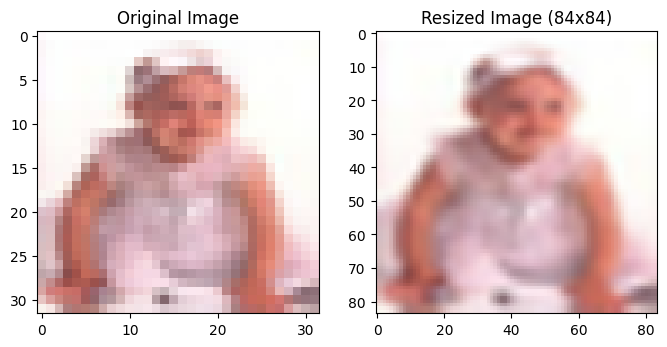

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# 打开图像
image_path = "data/cifar/test/baby/babe_s_000193.png"  # 替换为你的图像文件路径
original_image = Image.open(image_path)

# 调整图像大小为84x84
new_size = (84, 84)
resized_image = original_image.resize(new_size)

# 显示原始图像
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

# 显示调整大小后的图像
plt.subplot(1, 2, 2)
plt.imshow(resized_image)
plt.title("Resized Image (84x84)")
plt.show()


In [2]:
import torch

# 创建两个矩阵
matrix1 = torch.tensor([[1, 2], [3, 4]])
matrix2 = torch.tensor([[5, 6], [7, 8]])

# 对应元素相加
result = matrix1 + matrix2

print(result)

tensor([[ 6,  8],
        [10, 12]])


In [ ]:
import torch
import torch.nn.functional as F

# 创建示例张量
tensor = torch.tensor([[1.0, 2.0, 3.0],
                       [4.0, 5.0, 6.0]])

# 对张量的行进行归一化
normalized_tensor = F.normalize(tensor, p=2, dim=1)

print(normalized_tensor)

In [3]:
import torch

# 创建一个 (5, 5) 的示例 Tensor
original_tensor = torch.tensor([[1, 2, 3, 4, 5],
                                [6, 7, 8, 9, 10],
                                [11, 12, 13, 14, 15],
                                [16, 17, 18, 19, 20],
                                [21, 22, 23, 24, 25]])

# 使用循环拆分成五个子 Tensor
sub_tensors = [original_tensor[i:i+1, :] for i in range(5)]


print(sub_tensors)


[tensor([[1, 2, 3, 4, 5]]), tensor([[ 6,  7,  8,  9, 10]]), tensor([[11, 12, 13, 14, 15]]), tensor([[16, 17, 18, 19, 20]]), tensor([[21, 22, 23, 24, 25]])]
